In [33]:
%matplotlib inline
from matplotlib import pyplot as plt 
import numpy as np
import pandas as pd

#### Посмотрим на наши данные

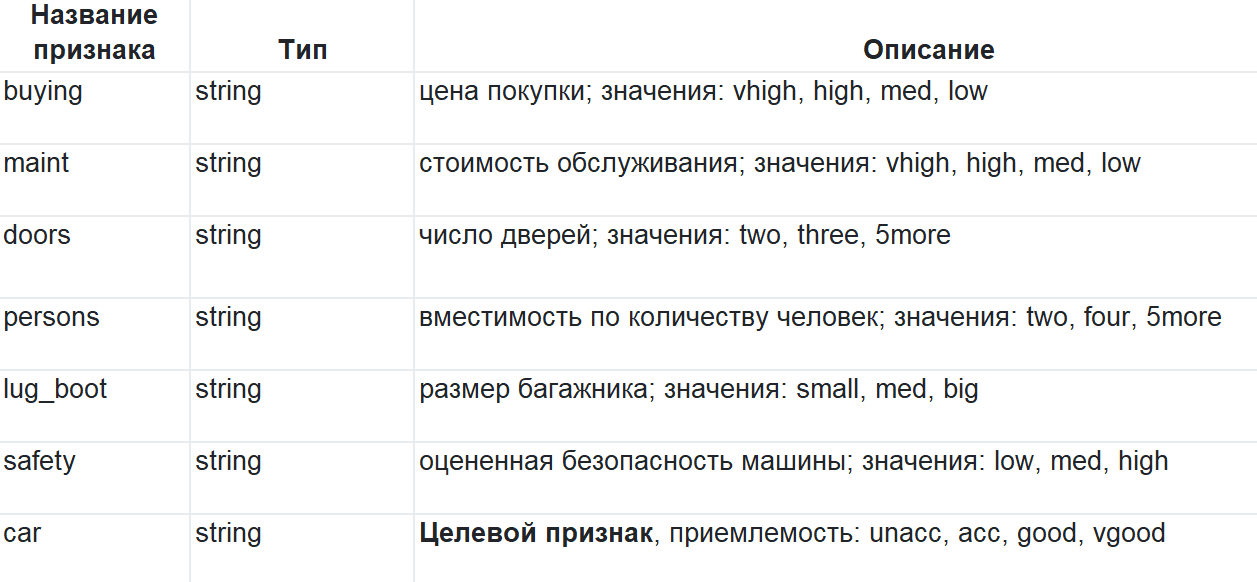

In [95]:
from IPython.display import Image
Image(filename='base_features.png', width=600) 

In [96]:
data = pd.read_csv('cars_dataset.csv')
data.head()

,buying,maint,doors,persons,lug_boot,safety,car
0,vhigh,vhigh,two,two,small,low,unacc
1,vhigh,vhigh,two,two,small,med,unacc
2,vhigh,vhigh,two,two,small,high,unacc
3,vhigh,vhigh,two,two,med,low,unacc
4,vhigh,vhigh,two,two,med,med,unacc


все признаки оказалась категориальными :(

In [97]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   car       1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


In [98]:
data.isna().any().sum(axis=0) # есть ли пропуски в данных

0

<BarContainer object of 4 artists>

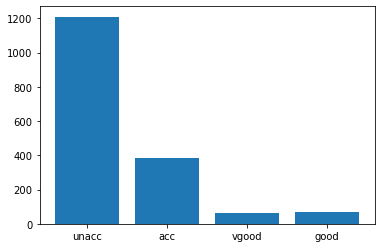

In [99]:
possible_values = data['car'].unique()
target = data['car'].copy()
target_count = list(map(lambda x: target[target == x].count(), possible_values))
plt.bar(possible_values, target_count)

Из данных видно: чем больше приемлимость, тем меньше подходящих автомобилей

In [100]:
y = data['car']
X = data.drop('car', axis=1)

In [101]:
label_class = {
    'acc': 0,
    'good': 1,
    'unacc': 2,
    'vgood': 3
}

y = y.map(label_class)

In [102]:
y.tail()

1723    1
1724    3
1725    2
1726    1
1727    3
Name: car, dtype: int64

In [103]:
X.head(3)

,buying,maint,doors,persons,lug_boot,safety
0,vhigh,vhigh,two,two,small,low
1,vhigh,vhigh,two,two,small,med
2,vhigh,vhigh,two,two,small,high


Проведем one-hot-кодирование

In [104]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
ohe_features = ohe.fit_transform(X)

column_names = []
for column in X.columns:
    values = set(X[column])
    column_names += list(map(lambda x: f"{column}_{x}", values))

X = pd.DataFrame(ohe_features, columns=column_names)

In [105]:
X.head(3)

,buying_low,buying_med,buying_vhigh,buying_high,maint_low,maint_med,maint_vhigh,maint_high,doors_5more,doors_three,...,doors_two,persons_four,persons_more,persons_two,lug_boot_big,lug_boot_small,lug_boot_med,safety_low,safety_med,safety_high
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


In [106]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=42)

In [46]:
from sklearn.linear_model import LogisticRegression

reg = LogisticRegression(max_iter=2000, n_jobs=-1, multi_class='multinomial')

Буду использовать метрику **precision, т.к. наш датасет несбалансированный** и метрика **accuracy не подходит**. А оценить правильную принадлежность к классу полезно. Это и есть то, к чему я стремлюсь.

In [47]:
from sklearn.model_selection import cross_val_score

errors = cross_val_score(reg, X_train, y_train, scoring='precision_micro')
avg_error = np.average(errors)
avg_error

0.89784077453507

###### Попытаемся сбалансировать датасет и добавим веса для классов

In [48]:
def get_dataset_balance_weigts(X, y, logging=False):
    classes = set(y)
    dataset_len = len(y)
    
    weigths = dict()
    
    for _class in classes:
        class_weigth = dataset_len / len(y[y==_class])
        weigths[_class] = class_weigth
        
        if logging:
            print(f"class: {_class}, quantity: {len(y[y==_class])}, weigth: {class_weigth}")
    
    return weigths

In [49]:
get_dataset_balance_weigts(X, y, True)

class: 0, quantity: 384, weigth: 4.5
class: 1, quantity: 69, weigth: 25.043478260869566
class: 2, quantity: 1210, weigth: 1.428099173553719
class: 3, quantity: 65, weigth: 26.584615384615386


{0: 4.5, 1: 25.043478260869566, 2: 1.428099173553719, 3: 26.584615384615386}

In [51]:
def warn(*args, **kwargs):
    pass
import warnings 
warnings.warn = warn  # спрячем ошибки от sklearn (когда penalty не подходит для solver)

### Переберем гиперпараметры для регрессии

In [54]:
def iter_reg_hyperparams(logging=True):
    iter_num = 0
    _best = 0

    
    C = np.arange(0.1, 1.3, 0.2) # smaller values specify stronger regularization
    intercept_scaling = np.arange(0.1, 1.3, 0.2) # to lessen the effect of regularization
    fit_intercept = (True, False) # bias
    penalty = ('l1', 'l2', 'elasticnet', 'none')

    solvers = ('newton-cg', 'sag', 'saga', 'lbfgs') # multiclass solvers
    class_weight = get_dataset_balance_weigts(X, y)
    
    
    for _c in C:
        for _scaling in intercept_scaling:
            for _penalty in penalty:
                for _intercept in fit_intercept:
                    for _solver in solvers:
                        reg = LogisticRegression(penalty=_penalty, C=_c, fit_intercept=_intercept,
                                                 intercept_scaling=_intercept, class_weight=class_weight,
                                                 random_state=42, solver=_solver, max_iter=2000)

                        _precisions = cross_val_score(reg, X, y, scoring='precision_micro')
                        avg_precision = np.average(_precisions)

                        if avg_precision > _best:
                            _best = avg_precision
                            _best_reg = reg

                        iter_num += 1
                        if not np.isnan(avg_precision) and logging:
                            print(f'{iter_num}. {avg_precision}.  BEST: {_best}')
    
    return _best_reg

In [55]:
%%time
best_reg = iter_reg_hyperparams()

3. 0.8089369188238251.  BEST: 0.8089369188238251
7. 0.8043143168300244.  BEST: 0.8089369188238251
9. 0.797330987685348.  BEST: 0.8089369188238251
10. 0.6353036776409484.  BEST: 0.8089369188238251
11. 0.5942112758649577.  BEST: 0.8089369188238251
12. 0.797330987685348.  BEST: 0.8089369188238251
13. 0.7840093825919411.  BEST: 0.8089369188238251
14. 0.6856429588673871.  BEST: 0.8089369188238251
15. 0.642285331322778.  BEST: 0.8089369188238251
16. 0.7845874172740219.  BEST: 0.8089369188238251
25. 0.8992544190332579.  BEST: 0.8992544190332579
26. 0.8789829940521068.  BEST: 0.8992544190332579
27. 0.8795576778084946.  BEST: 0.8992544190332579
28. 0.8992544190332579.  BEST: 0.8992544190332579
29. 0.8992544190332579.  BEST: 0.8992544190332579
30. 0.8552668174583229.  BEST: 0.8992544190332579
31. 0.8766842590265561.  BEST: 0.8992544190332579
32. 0.8992544190332579.  BEST: 0.8992544190332579
35. 0.8089369188238251.  BEST: 0.8992544190332579
39. 0.8043143168300244.  BEST: 0.8992544190332579
41. 0.

295. 0.8546703526849292.  BEST: 0.8992544190332579
297. 0.8291664572338109.  BEST: 0.8992544190332579
298. 0.6995777833626539.  BEST: 0.8992544190332579
299. 0.6347122392560945.  BEST: 0.8992544190332579
300. 0.8291664572338109.  BEST: 0.8992544190332579
301. 0.8170059478931055.  BEST: 0.8992544190332579
302. 0.7152165535729246.  BEST: 0.8992544190332579
303. 0.6491597553824244.  BEST: 0.8992544190332579
304. 0.8170059478931055.  BEST: 0.8992544190332579
313. 0.8992544190332579.  BEST: 0.8992544190332579
314. 0.8789829940521068.  BEST: 0.8992544190332579
315. 0.8795576778084946.  BEST: 0.8992544190332579
316. 0.8992544190332579.  BEST: 0.8992544190332579
317. 0.8992544190332579.  BEST: 0.8992544190332579
318. 0.8552668174583229.  BEST: 0.8992544190332579
319. 0.8766842590265561.  BEST: 0.8992544190332579
320. 0.8992544190332579.  BEST: 0.8992544190332579
323. 0.8153371868978805.  BEST: 0.8992544190332579
327. 0.8546703526849292.  BEST: 0.8992544190332579
329. 0.8291664572338109.  BEST:

579. 0.8934589930468292.  BEST: 0.8992544190332579
583. 0.8413621512942949.  BEST: 0.8992544190332579
585. 0.8511820390382843.  BEST: 0.8992544190332579
586. 0.6456312306274608.  BEST: 0.8992544190332579
587. 0.6931456814945129.  BEST: 0.8992544190332579
588. 0.8511820390382843.  BEST: 0.8992544190332579
589. 0.8407556337438218.  BEST: 0.8992544190332579
590. 0.7042020608193014.  BEST: 0.8992544190332579
591. 0.7168585071626037.  BEST: 0.8992544190332579
592. 0.8407556337438218.  BEST: 0.8992544190332579
601. 0.8992544190332579.  BEST: 0.8992544190332579
602. 0.8789829940521068.  BEST: 0.8992544190332579
603. 0.8795576778084946.  BEST: 0.8992544190332579
604. 0.8992544190332579.  BEST: 0.8992544190332579
605. 0.8992544190332579.  BEST: 0.8992544190332579
606. 0.8552668174583229.  BEST: 0.8992544190332579
607. 0.8766842590265561.  BEST: 0.8992544190332579
608. 0.8992544190332579.  BEST: 0.8992544190332579
611. 0.8934589930468292.  BEST: 0.8992544190332579
615. 0.8413621512942949.  BEST:

864. 0.8992544190332579.  BEST: 0.8992544190332579
867. 0.8662377481779341.  BEST: 0.8992544190332579
871. 0.8755047331825416.  BEST: 0.8992544190332579
873. 0.8587115690709559.  BEST: 0.8992544190332579
874. 0.7094228030493424.  BEST: 0.8992544190332579
875. 0.7469347407221244.  BEST: 0.8992544190332579
876. 0.8587115690709559.  BEST: 0.8992544190332579
877. 0.8482834883136465.  BEST: 0.8992544190332579
878. 0.695420960040211.  BEST: 0.8992544190332579
879. 0.7197319259445422.  BEST: 0.8992544190332579
880. 0.8482834883136465.  BEST: 0.8992544190332579
889. 0.8992544190332579.  BEST: 0.8992544190332579
890. 0.8789829940521068.  BEST: 0.8992544190332579
891. 0.8795576778084946.  BEST: 0.8992544190332579
892. 0.8992544190332579.  BEST: 0.8992544190332579
893. 0.8992544190332579.  BEST: 0.8992544190332579
894. 0.8552668174583229.  BEST: 0.8992544190332579
895. 0.8766842590265561.  BEST: 0.8992544190332579
896. 0.8992544190332579.  BEST: 0.8992544190332579
899. 0.8662377481779341.  BEST: 

1150. 0.8552668174583229.  BEST: 0.8992544190332579
1151. 0.8766842590265561.  BEST: 0.8992544190332579
1152. 0.8992544190332579.  BEST: 0.8992544190332579
Wall time: 1h 4min 11s


Вот такие параметры получились:

In [65]:
best_reg.get_params()

{'C': 0.1,
 'class_weight': {0: 4.5,
  1: 25.043478260869566,
  2: 1.428099173553719,
  3: 26.584615384615386},
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': True,
 'l1_ratio': None,
 'max_iter': 2000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'none',
 'random_state': 42,
 'solver': 'newton-cg',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Посмотрим на метрику **accuracy** нашей модели (обучали по precision)

In [71]:
accuracy = cross_val_score(best_reg, X, y, scoring='accuracy')
accuracy = np.average(accuracy)
accuracy

0.8992544190332579

Попробуем убрать балансировку классов и посмотрим на результат

In [72]:
unbalanced_reg = LogisticRegression(penalty='none', C=0.1, fit_intercept=True,
                                                 intercept_scaling=True, solver='newton-cg', max_iter=2000)

accuracy = cross_val_score(unbalanced_reg, X, y, scoring='accuracy')
accuracy = np.average(accuracy)
accuracy

0.8929010639189074

_Точность упала :(_

### Перейдем к хардкору и обучим нейросеть :)

In [81]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical 

In [107]:
y_train = to_categorical(y_train, 4)
y_test = to_categorical(y_test, 4)

In [126]:
model = Sequential()
model.add(Dense(500, activation='relu', input_dim=21))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer='adam', 
              loss='mse', 
              metrics=['accuracy', 'mse', 'mae', 'mape'])

In [127]:
history = model.fit(X_train, y_train, epochs=20)

Epoch 1/20
46/46 [==============================] - 0s 1ms/step - loss: 0.1034 - accuracy: 0.6996 - mse: 0.1034 - mae: 0.2246 - mape: 112289768.0000
Epoch 2/20
46/46 [==============================] - 0s 1ms/step - loss: 0.0451 - accuracy: 0.8794 - mse: 0.0451 - mae: 0.1071 - mape: 53543940.0000
Epoch 3/20
46/46 [==============================] - 0s 1ms/step - loss: 0.0254 - accuracy: 0.9251 - mse: 0.0254 - mae: 0.0676 - mape: 33787640.0000
Epoch 4/20
46/46 [==============================] - 0s 1ms/step - loss: 0.0134 - accuracy: 0.9741 - mse: 0.0134 - mae: 0.0419 - mape: 20933892.0000
Epoch 5/20
46/46 [==============================] - 0s 1ms/step - loss: 0.0076 - accuracy: 0.9891 - mse: 0.0076 - mae: 0.0287 - mape: 14369249.0000
Epoch 6/20
46/46 [==============================] - 0s 2ms/step - loss: 0.0040 - accuracy: 0.9952 - mse: 0.0040 - mae: 0.0177 - mape: 8853756.0000
Epoch 7/20
46/46 [==============================] - 0s 2ms/step - loss: 0.0025 - accuracy: 0.9966 - mse: 0.0025 

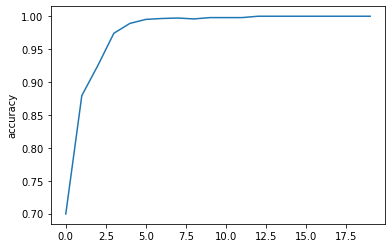

In [131]:
plt.ylabel('accuracy')
plt.plot(history.history['accuracy'])

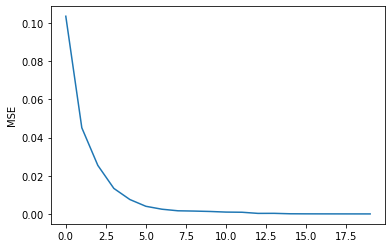

In [133]:
plt.ylabel('MSE')
plt.plot(history.history['mse'])

In [143]:
y_pred = model.predict(X_test)
scores = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy on test data: {} %'.format(scores[1] * 100))

Accuracy on test data: 100.0 %


#### Кажеться, мы научились предсказывать данные идеально :)
_Accuracy: 100%_